# This notebook provides the functionality to build, train, and test a CNN for predicting mosquito age, grouped age, species, and status.

## Structure:
* Import packages to be used.
* Load mosquito data.
* Define fucntions for plotting, visualisation, and logging.
* Define a function to build the CNN.
* Define a function to train the CNN.
* Main section to organise data, define the CNN, and call the building and training of the CNN.


In [1]:
import umap
import pylab as pl
import datetime
import pandas as pd
import itertools
from itertools import cycle
import pickle
import random as rn
import os
from time import time
from tqdm import tqdm

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils import resample

import tensorflow as tf
import keras
from keras.models import Sequential, Model, load_model
from keras import layers, metrics
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import model_from_json, load_model
from keras.regularizers import *
from keras.callbacks import CSVLogger
from keras import backend as K

Using TensorFlow backend.


In [2]:
# rand_seed = np.random.randint(low=0, high=100)
rand_seed = 16
print(rand_seed)

16


In [3]:
os.environ['PYTHONHASHSEED'] = '0'

## The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
np.random.seed(42)

## The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)

## Force TensorFlow to use single thread.
## Multiple threads are a potential source of
## non-reproducible results.
## For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
# session_conf = tf.ConfigProto(device_count = {'GPU':0}, intra_op_parallelism_threads=4) #session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# session_conf = tf.ConfigProto(device_count = {'GPU':0}) #session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#session_conf.gpu_options.per_process_gpu_memory_fraction = 0.5
## The below tf.set_random_seed() will make random number generation
## in the TensorFlow backend have a well-defined initial state.
## For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)

sess = tf.Session(graph=tf.get_default_graph(), config=tf.ConfigProto(gpu_options=gpu_options))
K.set_session(sess)

## Load the data

The data file is created using Loco Mosquito:
https://github.com/magonji/MIMI-project/blob/master/Loco%20mosquito%204.0.ipynb

### The data file has headings: Species - Status - RearCnd - Age - Country- Frequencies

In [17]:
class data_loader_class():
    def __init__(self, valid_perc, seed):
        df = pd.read_csv("../../Data/mosquitoes_country_LM_5_0.dat", '\t')
        df.head(10)

        df['AgeGroup'] = 0
        df['AgeGroup'] = np.where(df['Age']>10, 2, np.where(df['Age']>4, 1, 0))

        df_vf = df[df['RearCnd']=='VF']
        df_vf = df_vf[df_vf['Status']=='UN']
        df = df[df['RearCnd']!='VF']
        df = df[df['Status']!='UN']
        df_l = df[df['RearCnd']=='TL']
        df_l_g = df_l[df_l['Country']=='S']
        
        df_l_g_a = df_l_g[df_l_g['Species']=='AA']
        age_counts = df_l_g_a.groupby('AgeGroup').size()
        df_l_g_g = df_l_g[df_l_g['Species']=='AG']
        age_counts = df_l_g_g.groupby('AgeGroup').size()
        df_l_g_c = df_l_g[df_l_g['Species']=='AC']
        age_counts = df_l_g_c.groupby('AgeGroup').size()
        df_l_t = df_l[df_l['Country']=='T']
        df_l_t_a = df_l_t[df_l_t['Species']=='AA']
        age_counts = df_l_t_a.groupby('AgeGroup').size()
        df_l_t_g = df_l_t[df_l_t['Species']=='AG']
        age_counts = df_l_t_g.groupby('AgeGroup').size()
        df_l_b = df_l[df_l['Country']=='B']
        df_l_b_g = df_l_b[df_l_b['Species']=='AG']
        age_counts = df_l_b_g.groupby('AgeGroup').size()
        df_l_b_c = df_l_b[df_l_b['Species']=='AC']
        age_counts = df_l_b_c.groupby('AgeGroup').size()
        df_f = df[df['RearCnd']=='TF']
        df_f_t = df_f[df_f['Country']=='T']
        df_f_t_a = df_f_t[df_f_t['Species']=='AA']
        # df_f_t_g = df_f_t[df_f_t['Species']=='AG'] #There isn't any
        df_f_b = df_f[df_f['Country']=='B']
        df_f_b_g = df_f_b[df_f_b['Species']=='AG']
        age_counts = df_f_b_g.groupby('AgeGroup').size()
        df_f_b_c = df_f_b[df_f_b['Species']=='AC']
        age_counts = df_f_b_c.groupby('AgeGroup').size()
        df_vf_t = df_vf[df_vf['Country']=='T']
        df_vf_t_a = df_vf_t[df_vf_t['Species']=='AA']
        age_counts = df_vf_t_a.groupby('AgeGroup').size()
#         print(age_counts)
        df_vf_t_g = df_vf_t[df_vf_t['Species']=='AG']
        age_counts = df_vf_t_g.groupby('AgeGroup').size()
#         print(age_counts)
        df_vf_b = df_vf[df_vf['Country']=='B']
        df_vf_b_g = df_vf_b[df_vf_b['Species']=='AG']
        age_counts = df_vf_b_g.groupby('AgeGroup').size()
#         print(age_counts)
        df_vf_b_c = df_vf_b[df_vf_b['Species']=='AC']
        age_counts = df_vf_b_c.groupby('AgeGroup').size()
#         print(age_counts)

        VF_size_t = len(df_vf_t)
        VF_size_b = len(df_vf_b)
#         print('validation size tanzania : {}'.format(VF_size_t))
#         print('validation size bobo : {}'.format(VF_size_b))
        val_group_size_t = int(((((valid_perc*VF_size_t)/2)/3))) #/2 (t/b) /3 (age groups)
        val_group_size_b = int(((((valid_perc*VF_size_b)/2)/3)))
#         print('validation size for testing tanzania : {}'.format(val_group_size_t))
#         print('validation size for testing bobo : {}'.format(val_group_size_b))

        size_test = 20
        for age in range(3):
            df_temp = df_vf_t_a[df_vf_t_a['AgeGroup']==age]
            size_df_temp = np.arange(len(df_temp))
            if len(size_df_temp) < size_test:
                print('Warning Tanzania Arabiensis VF group {} smaller than amount requested'.format(age))
            np.random.seed(seed)
            np.random.shuffle(size_df_temp)
            index_df_temp_inc = size_df_temp[:size_test]
            index_df_temp_not_inc = size_df_temp[size_test:]
            if age == 0:
                df_test = df_temp.iloc[index_df_temp_inc]
                df_train_vf_t_a = df_temp.iloc[index_df_temp_not_inc]
            else:
                df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_inc]])
                df_train_vf_t_a = pd.concat([df_train_vf_t_a, df_temp.iloc[index_df_temp_not_inc]])
        for age in range(3):
            df_temp = df_vf_t_g[df_vf_t_g['AgeGroup']==age]
            size_df_temp = np.arange(len(df_temp))
            if len(size_df_temp) < size_test:
                print('Warning Tanzania Gambie VF group {} smaller than amount requested'.format(age))
            np.random.seed(seed)
            np.random.shuffle(size_df_temp)
            index_df_temp_inc = size_df_temp[:size_test]
            index_df_temp_not_inc = size_df_temp[size_test:]
            df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_inc]])
            if age == 0:
                df_train_vf_t_g = df_temp.iloc[index_df_temp_not_inc]
            else:
                df_train_vf_t_g = pd.concat([df_train_vf_t_g, df_temp.iloc[index_df_temp_not_inc]])
        size_test = 10
        for age in range(3):
            df_temp = df_vf_b_g[df_vf_b_g['AgeGroup']==age]
            size_df_temp = np.arange(len(df_temp))
            if len(size_df_temp) < size_test:
                print('Warning Bobo Gambie VF group {} smaller than amount requested'.format(age))
            np.random.seed(seed)
            np.random.shuffle(size_df_temp)
            index_df_temp_inc = size_df_temp[:size_test]
            index_df_temp_not_inc = size_df_temp[size_test:]
            df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_inc]])
            if age == 0:
                df_train_vf_b_g = df_temp.iloc[index_df_temp_not_inc]
            else:
                df_train_vf_b_g = pd.concat([df_train_vf_b_g, df_temp.iloc[index_df_temp_not_inc]])
        for age in range(3):
            df_temp = df_vf_b_c[df_vf_b_c['AgeGroup']==age]
            size_df_temp = np.arange(len(df_temp))
            if len(size_df_temp) < size_test:
                print('Warning Bobo Colluzzi VF group {} smaller than amount requested'.format(age))
            np.random.seed(seed)
            np.random.shuffle(size_df_temp)
            index_df_temp_inc = size_df_temp[:size_test]
            index_df_temp_not_inc = size_df_temp[size_test:]
            df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_inc]])
            if age == 0:
                df_train_vf_b_c = df_temp.iloc[index_df_temp_not_inc]
            else:
                df_train_vf_b_c = pd.concat([df_train_vf_b_c, df_temp.iloc[index_df_temp_not_inc]])

#         size_inc = 400
#         for age in range(3):
#             df_temp = df_l_t_a[df_l_t_a['AgeGroup']==age]
#             size_df_temp = np.arange(len(df_temp))
#             np.random.seed(42)
#             np.random.shuffle(size_df_temp)
#             index_df_temp_inc = size_df_temp[:size_inc]
#             index_df_temp_not_inc = size_df_temp[size_inc:]
#             if age == 0:
#                 df_train = df_temp.iloc[index_df_temp_inc]
#         #         df_test = df_temp.iloc[index_df_temp_not_inc]
#             else:
#                 df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#         #         df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
#         for age in range(3):
#             df_temp = df_l_t_g[df_l_t_g['AgeGroup']==age]
#             size_df_temp = np.arange(len(df_temp))
#             np.random.seed(42)
#             np.random.shuffle(size_df_temp)
#             index_df_temp_inc = size_df_temp[:size_inc]
#             index_df_temp_not_inc = size_df_temp[size_inc:]
#             df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#         #     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
#         size_inc = 400
#         for age in range(3):
#             df_temp = df_l_b_g[df_l_b_g['AgeGroup']==age]
#             size_df_temp = np.arange(len(df_temp))
#             np.random.seed(42)
#             np.random.shuffle(size_df_temp)
#             index_df_temp_inc = size_df_temp[:size_inc]
#             index_df_temp_not_inc = size_df_temp[size_inc:]
#             df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#         #     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
#         for age in range(3):
#             df_temp = df_l_b_c[df_l_b_c['AgeGroup']==age]
#             size_df_temp = np.arange(len(df_temp))
#             np.random.seed(42)
#             np.random.shuffle(size_df_temp)
#             index_df_temp_inc = size_df_temp[:size_inc]
#             index_df_temp_not_inc = size_df_temp[size_inc:]
#             df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#         #     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
#         size_inc = 300
#         for age in range(3):
#             df_temp = df_f_t_a[df_f_t_a['AgeGroup']==age]
#             size_df_temp = np.arange(len(df_temp))
#             np.random.seed(42)
#             np.random.shuffle(size_df_temp)
#             index_df_temp_inc = size_df_temp[:size_inc]
#             index_df_temp_not_inc = size_df_temp[size_inc:]
#             df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#         #     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
#         for age in range(3):
#             df_temp = df_f_b_g[df_f_b_g['AgeGroup']==age]
#             size_df_temp = np.arange(len(df_temp))
#             np.random.seed(42)
#             np.random.shuffle(size_df_temp)
#             index_df_temp_inc = size_df_temp[:size_inc]
#             index_df_temp_not_inc = size_df_temp[size_inc:]
#             df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#         #     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
#         size_inc = 300
#         for age in range(3):
#             df_temp = df_f_b_c[df_f_b_c['AgeGroup']==age]
#             size_df_temp = np.arange(len(df_temp))
#             np.random.seed(42)
#             np.random.shuffle(size_df_temp)
#             index_df_temp_inc = size_df_temp[:size_inc]
#             index_df_temp_not_inc = size_df_temp[size_inc:]
#             df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#         #     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
        size_inc = val_group_size_t
        for age in range(3):
            df_temp = df_train_vf_t_a[df_train_vf_t_a['AgeGroup']==age]
            size_df_temp = np.arange(len(df_temp))
            if len(size_df_temp) < size_inc:
                print('Warning Tanzania Arabiensis VF group {} smaller than amount requested'.format(age))
            np.random.seed(seed)
            np.random.shuffle(size_df_temp)
            index_df_temp_inc = size_df_temp[:size_inc]
            index_df_temp_not_inc = size_df_temp[size_inc:]
#             df_train = df_temp.iloc[index_df_temp_inc]#pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
            if age == 0:
                df_train = df_temp.iloc[index_df_temp_inc]
#                 df_test = df_temp.iloc[index_df_temp_not_inc]
            else:
                df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#                 df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
        for age in range(3):
            df_temp = df_train_vf_t_g[df_train_vf_t_g['AgeGroup']==age]
            size_df_temp = np.arange(len(df_temp))
            if len(size_df_temp) < size_inc:
                print('Warning Tanzania Gambie VF group {} smaller than amount requested'.format(age))
            np.random.seed(seed)
            np.random.shuffle(size_df_temp)
            index_df_temp_inc = size_df_temp[:size_inc]
            index_df_temp_not_inc = size_df_temp[size_inc:]
            df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#             df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
        size_inc = val_group_size_b
        for age in range(3):
            df_temp = df_train_vf_b_g[df_train_vf_b_g['AgeGroup']==age]
            size_df_temp = np.arange(len(df_temp))
            if len(size_df_temp) < size_inc:
                print('Warning Bobo Gambie VF group {} smaller than amount requested'.format(age))
            np.random.seed(seed)
            np.random.shuffle(size_df_temp)
            index_df_temp_inc = size_df_temp[:size_inc]
            index_df_temp_not_inc = size_df_temp[size_inc:]
            df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#             df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
        for age in range(3):
            df_temp = df_train_vf_b_c[df_train_vf_b_c['AgeGroup']==age]
            size_df_temp = np.arange(len(df_temp))
            if len(size_df_temp) < size_inc:
                print('Warning Bobo Colluzzi VF group {} smaller than amount requested'.format(age))
            np.random.seed(seed)
            np.random.shuffle(size_df_temp)
            index_df_temp_inc = size_df_temp[:size_inc]
            index_df_temp_not_inc = size_df_temp[size_inc:]
            df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#             df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])

        print('Percentage of field mosquitoes inc {} - Num mosquitoes {} / {}'.format(valid_perc*100, len(df_train[df_train['RearCnd']=='VF']), len(df_vf)))
        print('Total number of mosquitoes in the Train set {}'.format(len(df_train)))
        print('Total number of mosquitoes in the Test set {}'.format(len(df_test)))
        
        X = df_train.iloc[:,6:-1]
        y_age = df_train["Age"]
        y_age_groups = df_train["AgeGroup"]
        y_species = df_train["Species"]
        y_status = df_train["Status"]
#         print('shape of X : {}'.format(X.shape))
#         print('shape of y age : {}'.format(y_age.shape))
#         print('shape of y age groups : {}'.format(y_age_groups.shape))
#         print('shape of y species : {}'.format(y_species.shape))
#         print('shape of y status : {}'.format(y_status.shape))
        self.X = np.asarray(X)
        y_age = np.asarray(y_age)
        self.y_age_groups = np.asarray(y_age_groups)
        self.y_species = np.asarray(y_species)
        y_status = np.asarray(y_status)

        X_vf = df_test.iloc[:,6:-1]
        y_age_vf = df_test["Age"]
        y_age_groups_vf = df_test["AgeGroup"]
        y_species_vf = df_test["Species"]
        y_status_vf = df_test["Status"]
#         print('shape of X_vf : {}'.format(X_vf.shape))
#         print('shape of y_age_vf age : {}'.format(y_age_vf.shape))
#         print('shape of y_age_groups_vf : {}'.format(y_age_groups_vf.shape))
#         print('shape of y y_species_vf : {}'.format(y_species_vf.shape))
#         print('shape of y y_status_vf : {}'.format(y_status_vf.shape))
        self.X_vf = np.asarray(X_vf)
        y_age_vf = np.asarray(y_age_vf)
        self.y_age_groups_vf = np.asarray(y_age_groups_vf)
        self.y_species_vf = np.asarray(y_species_vf)
        y_status_vf = np.asarray(y_status_vf)



In [18]:
def data_loader(valid_perc, seed):
    return data_loader_class(valid_perc, seed)

## Function used to create a new folder for the CNN outputs.
Useful to stop forgetting to name a new folder when trying out a new model varient and overwriting a days training.

In [19]:
def build_folder(fold, to_build = False):
    if not os.path.isdir(fold):
        if to_build == True:
            os.mkdir(fold)
        else:
            print('Directory does not exists, not creating directory!')
    else:
        if to_build == True:
            raise NameError('Directory already exists, cannot be created!')

## Function for plotting confusion matrcies
This normalizes the confusion matrix and ensures neat plotting for all outputs.

In [7]:
def plot_confusion_matrix(cm, classes, output, save_path, model_name, fold,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          printout=False):

    font = {'weight' : 'normal',
            'size'   : 18}

    matplotlib.rc('font', **font)

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if printout:
            print("Normalized confusion matrix")
    else:
        if printout:
            print('Confusion matrix, without normalization')

    if printout:
        print(cm)
    
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1) # np.max(np.sum(cm, axis=1)))
#     plt.title([title+' - '+model_name])
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylim(2.5,-0.5)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout(pad=2)
#     plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig((save_path+"Confusion_Matrix_"+model_name+"_"+fold+"_"+output[1:]+".pdf"))
    plt.close()

## Function used for visualizing outputs
This splits the output data into the four categories before plotting the confusion matricies.

In [8]:
## for visualizing losses and metrics once the neural network fold is trained
def visualize(histories, save_path, model_name, fold, classes, outputs, predicted, true, title='Confusion Matrix'):
    # Sort out predictions and true labels
    for label_predictions_arr, label_true_arr, classes, outputs in zip(predicted, true, classes, outputs):
        classes_pred = np.argmax(label_predictions_arr, axis=-1)
        classes_true = np.argmax(label_true_arr, axis=-1)
        cnf_matrix = confusion_matrix(classes_true, classes_pred)
        plot_confusion_matrix(cnf_matrix, classes, outputs, save_path, model_name, fold, title=title)

## Data logging

In [9]:
## for logging data associated with the model
def log_data(log, name, fold, save_path):
    f = open((save_path+name+'_'+str(fold)+'_log.txt'), 'w')
    np.savetxt(f, log)
    f.close()

In [10]:
def save_obj(obj, name, savedir_main):
    with open(savedir_main + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [11]:
def load_obj(name, savedir_main):
    with open(savedir_main + name + '.pkl', 'rb') as f:
        return pickle.load(f)

## Fucntion for graphing the training data
This fucntion creates tidy graphs of loss and accuracy as the models are training.

In [12]:
def graph_history(history, model_name, model_ver_num, fold, save_path):

    font = {'weight' : 'normal',
            'size'   : 18}

    matplotlib.rc('font', **font)
    
    #not_validation = list(filter(lambda x: x[0:3] != "val", history.history.keys()))
#     print('history.history.keys : {}'.format(history.history.keys()))
    filtered = filter(lambda x: x[0:3] != "val", history.history.keys())
    not_validation = list(filtered)
    for i in not_validation:
        plt.figure(figsize=(15,7))
#         plt.title(i+"/ "+"val_"+i)
        plt.plot(history.history[i], label=i)
        plt.plot(history.history["val_"+i], label="val_"+i)
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel(i)
        plt.savefig(save_path +model_name+"_"+str(model_ver_num)+"_"+str(fold)+"_"+i+".png")
        plt.close()

## funciton to create the CNN
This function takes as an input a list of dictionaries. Each element in the list is a new hidden layer in the model. For each layer the dictionary defines the layer to be used.

### Available options are:
Convolutional Layer:
* type = 'c'
* filter = optional number of filters
* kernel = optional size of the filters
* stride = optional size of stride to take between filters
* pooling = optional width of the max pooling
* {'type':'c', 'filter':16, 'kernel':5, 'stride':1, 'pooling':2}

dense layer:
* type = 'd'
* width = option width of the layer
* {'type':'d', 'width':500}

In [13]:
def create_models(model_shape, input_layer_dim):
    
    regConst = 0.02
    sgd = keras.optimizers.SGD(lr=0.003, decay=1e-5, momentum=0.9, nesterov=True, clipnorm=1.)
    cce = 'categorical_crossentropy'

    if SelectFreqs:
        input_vec = Input(name='input', shape=(input_layer_dim,))
        xd = Dense(name='d1', units=500, activation='relu', 
                     kernel_regularizer=l2(regConst), 
                     kernel_initializer='he_normal')(input_vec)
        xd = BatchNormalization(name='batchnorm_1')(xd)
        
    else:
        input_vec = Input(name='input', shape=(input_layer_dim,1))
        
        xd = Flatten()(input_vec)

        xd = Dropout(name=('dout1'), rate=0.5)(xd)
        xd = Dense(name=('d1'), units=500, activation='relu', 
         kernel_regularizer=l2(regConst), 
         kernel_initializer='he_normal')(xd)
        xd = BatchNormalization(name=('batchnorm_1'))(xd)
        
        xd = Dropout(name=('dout2'), rate=0.5)(xd)
        xd = Dense(name=('d2'), units=500, activation='relu', 
         kernel_regularizer=l2(regConst), 
         kernel_initializer='he_normal')(xd)
        xd = BatchNormalization(name=('batchnorm_2'))(xd)
        
    
    xAgeGroup     = Dense(name = 'age_group', units = 3, 
                     activation = 'softmax', 
                     kernel_regularizer = l2(regConst), 
                     kernel_initializer = 'he_normal')(xd)
    xSpecies = Dense(name ='species', units = 3, 
                     activation = 'softmax', 
                     kernel_regularizer = l2(regConst), 
                     kernel_initializer = 'he_normal')(xd)

    outputs = []
#     for i in ['xAge', 'xAgeGroup', 'xSpecies']:
    for i in ['xAgeGroup', 'xSpecies']:
        outputs.append(locals()[i])
    model = Model(inputs = input_vec, outputs = outputs)
    
    model.compile(loss=cce, metrics=['acc'], 
                  optimizer=sgd)
#     model.summary()
    return model

## Function to train the model

This function will split the data into training and validation and call the create models function. This fucntion returns the model and training history.

In [25]:
def train_models(model_to_test, save_path, SelectFreqs=False):

    model_shape = model_to_test["model_shape"][0]
    model_name = model_to_test["model_name"][0]
#     input_layer_dim = model_to_test["input_layer_dim"][0]
    model_ver_num = model_to_test["model_ver_num"][0]
    fold = model_to_test["fold"][0]
    label = model_to_test["labels"][0]
    features = model_to_test["features"][0]
    classes = model_to_test["classes"][0]
    outputs = model_to_test["outputs"][0]
    compile_loss = model_to_test["compile_loss"][0]
    compile_metrics = model_to_test["compile_metrics"][0]

    ## Split into training / testing
    test_splits = train_test_split(features, *(label), test_size=0.1, shuffle=True, random_state=rand_seed)
    ## Pack up data
    X_train = test_splits.pop(0)
    X_val = test_splits.pop(0)
    y_train = test_splits[::2]
    y_val = test_splits[1::2]
    
#     out_model = create_models(model_shape, input_layer_dim)
    model = load_model("Results_Paper/Trian_Lab_Field_V2/Baseline_CNN_Model.h5")
    model.summary()
    for layer in model.layers[:-5]:
        layer.trainable = False
    for layer in model.layers:
        print(f'{layer.name} : {layer.trainable}')
        
    history = model.fit(x = X_train, 
                            y = y_train,
                            batch_size = 128*16, 
                            verbose = 0, 
                            epochs = 8000,
                            validation_data = (X_val, y_val),
                            callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                        patience=400, verbose=0, mode='auto'), 
                                        CSVLogger(save_path+model_name+"_"+str(model_ver_num)+'.csv', append=True, separator=';')])
    scores = model.evaluate(X_val, y_val)
#     print(out_model.metrics_names)
    
#     ## Kfold training
#     seed = rand_seed
#     kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
#     ## Split data into test and train
    
#     model_ver_num = 0
#     cv_scores = []
#     best_score = 0
#     for train_index, val_index in kfold.split(features):
#         print('Fold {} Running'.format(model_ver_num))
        
#         X_train, X_val = features[train_index], features[val_index]
#         y_train, y_val = list(map(lambda y:y[train_index], label)), list(map(lambda y:y[val_index], label))

#         model = create_models(model_shape, input_layer_dim)
#         if model_ver_num == 0:
#             model.summary()

#         history = model.fit(x = X_train, 
#                             y = y_train,
#                             batch_size = 128*16, 
#                             verbose = 0, 
#                             epochs = 8000,
#                             validation_data = (X_val, y_val),
#                             callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', 
#                                         patience=400, verbose=0, mode='auto'), 
#                                         CSVLogger(save_path+model_name+"_"+str(model_ver_num)+'.csv', append=True, separator=';')])
#         scores = model.evaluate(X_val, y_val)
#         print(model.metrics_names)
#         print(scores)
#         if (scores[3] + scores[4]) > best_score:
#             out_model = model
#             out_history = history
        
#         model_ver_num += 1
        
#         # Clear the Keras session, otherwise it will keep adding new
#         # models to the same TensorFlow graph each time we create
#         # a model with a different set of hyper-parameters.
#         K.clear_session()

#         # Delete the Keras model with these hyper-parameters from memory.
#         del model
        
    model.save((save_path+model_name+"_"+'Model.h5'))
    graph_history(history, model_name, 0, 0, save_path)
    
    return model, history

In [15]:
def load_only_models():

    model = load_model("Results_Paper/Trian_Lab_Field_V2/Baseline_CNN_Model.h5")
    model.summary()
    for layer in model.layers[:-5]:
        layer.trainable = False
    for layer in model.layers:
        print(f'{layer.name} : {layer.trainable}')
    
    return model

## Main section

Functionality:
* Oganises the data into a format of lists of data, classes, labels.
* Define the CNN to be built.
* Define the KFold validation to be used.
* Build a folder to output data into.
* Standardize and oragnise data into training/testing.
* Call the model training.
* Organize outputs and call visualization for plotting and graphing.


In [20]:
## Name a folder for the outputs to go into
outdir = "Results_Paper/"
build_folder(outdir, False)

savedir_main = (outdir+"Trian_Val_Only_Fix_Test_Retrain_Repeats/")
build_folder(savedir_main, True)

# val_results = {'loss':[[], [], [], [], [], [], [], [], [], []], 
#                'age_group_loss':[[], [], [], [], [], [], [], [], [], []], 
#                'species_loss':[[], [], [], [], [], [], [], [], [], []], 
#                'age_group_acc':[[], [], [], [], [], [], [], [], [], []], 
#                'species_acc':[[], [], [], [], [], [], [], [], [], []]}
val_results = {'loss':[], 
               'age_group_loss':[], 
               'species_loss':[], 
               'age_group_acc':[], 
               'species_acc':[]}
histories = []

start_time = time()

# for idx, valid_inc_perc in enumerate([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]):
for idx, valid_inc_perc in enumerate([0]):
    
    savedir_1 = (savedir_main+"valid_data_inc_"+str(valid_inc_perc)+"/")
    build_folder(savedir_1, True)
    
    for repeat in range(20):
        
        savedir = (savedir_1+"repeat_"+str(repeat)+"/")
        build_folder(savedir, True)

        data_extract = data_loader(valid_inc_perc, seed=repeat)

        ## Input CNN Size
#         input_layer_dim = len(data_extract.X[0])

        ## Transform Data
        y_age_groups_list = [[age] for age in data_extract.y_age_groups]
        y_species_list = [[species] for species in data_extract.y_species]
        age_groups = MultiLabelBinarizer().fit_transform(np.array(y_age_groups_list))
        age_group_classes = ["1-4", "5-10", "11-17"]
        species = MultiLabelBinarizer().fit_transform(np.array(y_species_list))
        species_classes = list(np.unique(y_species_list))
        y_age_groups_list_vf = [[age] for age in data_extract.y_age_groups_vf]
        y_species_list_vf = [[species] for species in data_extract.y_species_vf]
        age_groups_vf = MultiLabelBinarizer().fit_transform(np.array(y_age_groups_list_vf))
        species_vf = MultiLabelBinarizer().fit_transform(np.array(y_species_list_vf))

        ## Labels
        labels_default, classes_default, outputs_default = [age_groups, species], [age_group_classes, species_classes], ['xAgeGroup', 'xSpecies']
        labels_default_vf, classes_default_vf, outputs_default_vf = [age_groups_vf, species_vf], [age_group_classes, species_classes], ['xAgeGroup', 'xSpecies']

        ## Declare and train the model
        model_size = [{'type':'c', 'filter':16, 'kernel':8, 'stride':1, 'pooling':1},
                     {'type':'c', 'filter':16, 'kernel':8, 'stride':2, 'pooling':1},
                     {'type':'c', 'filter':16, 'kernel':3, 'stride':1, 'pooling':1},
                     {'type':'c', 'filter':16, 'kernel':6, 'stride':2, 'pooling':1},
                     {'type':'c', 'filter':16, 'kernel':5, 'stride':1, 'pooling':2},
                     {'type':'d', 'width':500}]

        ## Name the model
        model_name = ('Valid_Inc_'+str(valid_inc_perc))

        ## Scale train, test
        scl = StandardScaler()
        features_scl = scl.fit(X=np.vstack((data_extract.X, data_extract.X_vf)))
        if valid_inc_perc != 0:
            X_train = features_scl.transform(X=data_extract.X)
        X_test = features_scl.transform(X=data_extract.X_vf)

        ## Split data into test and train
        y_train, y_test = list(map(lambda y:y, labels_default)), list(map(lambda y:y, labels_default_vf))

        if valid_inc_perc != 0:
            X_train = np.expand_dims(X_train, axis=2)
        X_test = np.expand_dims(X_test, axis=2)

        if valid_inc_perc != 0:
            model_to_test = {
                "model_shape" : [model_size], # defines the hidden layers of the model
                "model_name"  : [model_name],
    #             "input_layer_dim"  : [input_layer_dim], # size of input layer
                "model_ver_num"  : [0],
                "fold"  : [0], # kf.split number on
                "labels"   : [y_train],
                "features" : [X_train],
                "classes"  : [classes_default],
                "outputs"   : [outputs_default],
                "compile_loss": [{'age': 'categorical_crossentropy'}],
                "compile_metrics" :[{'age': 'accuracy'}]
            }                

        ## Call function to train all the models from the dictionary
        if valid_inc_perc == 0:
            model = load_only_models()
        else:
            model, history = train_models(model_to_test, savedir)
            histories.append(history)
        
        
        predicted_labels = list([] for i in range(len(y_train)))
        true_labels = list([] for i in range(len(y_train)))

        y_predicted = model.predict(X_test)
        temp_eval = model.evaluate(X_test, y_test)
        for metric, res in zip(model.metrics_names, temp_eval):
            val_results[metric].append(res)
        print(val_results)

        predicted_labels = [x+[y] for x,y in zip(predicted_labels,y_predicted)]
        true_labels = [x+[y] for x,y in zip(true_labels,y_test)]

        predicted_labels = [predicted_labels[i][0].tolist() for i in range(len(predicted_labels))]
        true_labels = [true_labels[i][0].tolist() for i in range(len(true_labels))]

        ## Visualize the results
        visualize(histories, savedir, model_name, "0", classes_default, outputs_default, predicted_labels, true_labels)

        # Clear the Keras session, otherwise it will keep adding new
        # models to the same TensorFlow graph each time we create
        # a model with a different set of hyper-parameters.
        K.clear_session()

        # Delete the Keras model with these hyper-parameters from memory.
        del model

end_time = time()
print('Run time : {} s'.format(end_time-start_time))
print('Run time : {} m'.format((end_time-start_time)/60))
print('Run time : {} h'.format((end_time-start_time)/3600))

save_obj(val_results, f'Validation_Results_Dict_{valid_inc_perc}', savedir_main)

Percentage of field mosquitoes inc 0 - Num mosquitoes 0 / 3277
Total number of mosquitoes in the Train set 0
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
__________________________________________________________________________________________________
d1 (Dense)                      (None, 500)         

180/180 [==============================] - 0s 349us/step
{'loss': [3.0040559662712947, 3.134001440472073, 2.7936242156558566], 'age_group_loss': [1.2304464207755195, 1.3036530706617566, 1.2396360317866006], 'species_loss': [1.6312311967213948, 1.687970018386841, 1.4116098430421617], 'age_group_acc': [0.4388888888888889, 0.3944444431198968, 0.46111110978656344], 'species_acc': [0.3555555548932817, 0.3444444437821706, 0.42222222288449607]}
Percentage of field mosquitoes inc 0 - Num mosquitoes 0 / 3277
Total number of mosquitoes in the Train set 0
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatte

180/180 [==============================] - 0s 347us/step
{'loss': [3.0040559662712947, 3.134001440472073, 2.7936242156558566, 2.881973383161757, 2.877089426252577, 2.9680154535505507], 'age_group_loss': [1.2304464207755195, 1.3036530706617566, 1.2396360317866006, 1.2448991537094116, 1.1890195820066665, 1.2536846584743924], 'species_loss': [1.6312311967213948, 1.687970018386841, 1.4116098430421617, 1.4946958780288697, 1.5456915272606744, 1.5719525072309706], 'age_group_acc': [0.4388888888888889, 0.3944444431198968, 0.46111110978656344, 0.4277777784400516, 0.44444444510671827, 0.4555555582046509], 'species_acc': [0.3555555548932817, 0.3444444437821706, 0.42222222288449607, 0.4499999986754523, 0.41111111177338494, 0.3944444451067183]}
Percentage of field mosquitoes inc 0 - Num mosquitoes 0 / 3277
Total number of mosquitoes in the Train set 0
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Lay

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
__________________________________________________________________________________________________
d1 (Dense)                      (None, 500)          813000      dout1[0][0]                      
__________________________________________________________________________________________________
batchnorm_

180/180 [==============================] - 0s 391us/step
{'loss': [3.0040559662712947, 3.134001440472073, 2.7936242156558566, 2.881973383161757, 2.877089426252577, 2.9680154535505507, 2.774052153693305, 2.929411506652832, 2.8911734951867, 3.0598092079162598, 3.0001597616407607], 'age_group_loss': [1.2304464207755195, 1.3036530706617566, 1.2396360317866006, 1.2448991537094116, 1.1890195820066665, 1.2536846584743924, 1.2034493313895331, 1.397660493850708, 1.3664403094185724, 1.2969184319178264, 1.3074656062655978], 'species_loss': [1.6312311967213948, 1.687970018386841, 1.4116098430421617, 1.4946958780288697, 1.5456915272606744, 1.5719525072309706, 1.42822445763482, 1.3893726958168877, 1.382354904545678, 1.6205124696095785, 1.5503158118989733], 'age_group_acc': [0.4388888888888889, 0.3944444431198968, 0.46111110978656344, 0.4277777784400516, 0.44444444510671827, 0.4555555582046509, 0.42222222354676986, 0.41111110978656346, 0.41111110978656346, 0.38888888955116274, 0.4499999986754523], 's

Percentage of field mosquitoes inc 0 - Num mosquitoes 0 / 3277
Total number of mosquitoes in the Train set 0
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
__________________________________________________________________________________________________
d1 (Dense)                      (None, 500)         

Percentage of field mosquitoes inc 0 - Num mosquitoes 0 / 3277
Total number of mosquitoes in the Train set 0
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
__________________________________________________________________________________________________
d1 (Dense)                      (None, 500)         

Percentage of field mosquitoes inc 0 - Num mosquitoes 0 / 3277
Total number of mosquitoes in the Train set 0
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
__________________________________________________________________________________________________
d1 (Dense)                      (None, 500)         

Percentage of field mosquitoes inc 0 - Num mosquitoes 0 / 3277
Total number of mosquitoes in the Train set 0
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
__________________________________________________________________________________________________
d1 (Dense)                      (None, 500)         

In [26]:
## Name a folder for the outputs to go into
outdir = "Results_Paper/"
build_folder(outdir, False)

savedir_main = (outdir+"Trian_Val_Only_Fix_Test_Retrain_Repeats/")
build_folder(savedir_main, False)

# val_results = {'loss':[[], [], [], [], [], [], [], [], [], []], 
#                'age_group_loss':[[], [], [], [], [], [], [], [], [], []], 
#                'species_loss':[[], [], [], [], [], [], [], [], [], []], 
#                'age_group_acc':[[], [], [], [], [], [], [], [], [], []], 
#                'species_acc':[[], [], [], [], [], [], [], [], [], []]}
val_results = {'loss':[], 
               'age_group_loss':[], 
               'species_loss':[], 
               'age_group_acc':[], 
               'species_acc':[]}
histories = []

start_time = time()

for idx, valid_inc_perc in enumerate([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]):
# for idx, valid_inc_perc in enumerate([0]):
    
    savedir_1 = (savedir_main+"valid_data_inc_"+str(valid_inc_perc)+"/")
    build_folder(savedir_1, True)
    
    for repeat in range(20):
        
        savedir = (savedir_1+"repeat_"+str(repeat)+"/")
        build_folder(savedir, True)

        data_extract = data_loader(valid_inc_perc, seed=repeat)

        ## Input CNN Size
#         input_layer_dim = len(data_extract.X[0])

        ## Transform Data
        y_age_groups_list = [[age] for age in data_extract.y_age_groups]
        y_species_list = [[species] for species in data_extract.y_species]
        age_groups = MultiLabelBinarizer().fit_transform(np.array(y_age_groups_list))
        age_group_classes = ["1-4", "5-10", "11-17"]
        species = MultiLabelBinarizer().fit_transform(np.array(y_species_list))
        species_classes = list(np.unique(y_species_list))
        y_age_groups_list_vf = [[age] for age in data_extract.y_age_groups_vf]
        y_species_list_vf = [[species] for species in data_extract.y_species_vf]
        age_groups_vf = MultiLabelBinarizer().fit_transform(np.array(y_age_groups_list_vf))
        species_vf = MultiLabelBinarizer().fit_transform(np.array(y_species_list_vf))

        ## Labels
        labels_default, classes_default, outputs_default = [age_groups, species], [age_group_classes, species_classes], ['xAgeGroup', 'xSpecies']
        labels_default_vf, classes_default_vf, outputs_default_vf = [age_groups_vf, species_vf], [age_group_classes, species_classes], ['xAgeGroup', 'xSpecies']

        ## Declare and train the model
        model_size = [{'type':'c', 'filter':16, 'kernel':8, 'stride':1, 'pooling':1},
                     {'type':'c', 'filter':16, 'kernel':8, 'stride':2, 'pooling':1},
                     {'type':'c', 'filter':16, 'kernel':3, 'stride':1, 'pooling':1},
                     {'type':'c', 'filter':16, 'kernel':6, 'stride':2, 'pooling':1},
                     {'type':'c', 'filter':16, 'kernel':5, 'stride':1, 'pooling':2},
                     {'type':'d', 'width':500}]

        ## Name the model
        model_name = ('Valid_Inc_'+str(valid_inc_perc))

        ## Scale train, test
        scl = StandardScaler()
        features_scl = scl.fit(X=np.vstack((data_extract.X, data_extract.X_vf)))
        if valid_inc_perc != 0:
            X_train = features_scl.transform(X=data_extract.X)
        X_test = features_scl.transform(X=data_extract.X_vf)

        ## Split data into test and train
        y_train, y_test = list(map(lambda y:y, labels_default)), list(map(lambda y:y, labels_default_vf))

        if valid_inc_perc != 0:
            X_train = np.expand_dims(X_train, axis=2)
        X_test = np.expand_dims(X_test, axis=2)

        if valid_inc_perc != 0:
            model_to_test = {
                "model_shape" : [model_size], # defines the hidden layers of the model
                "model_name"  : [model_name],
    #             "input_layer_dim"  : [input_layer_dim], # size of input layer
                "model_ver_num"  : [0],
                "fold"  : [0], # kf.split number on
                "labels"   : [y_train],
                "features" : [X_train],
                "classes"  : [classes_default],
                "outputs"   : [outputs_default],
                "compile_loss": [{'age': 'categorical_crossentropy'}],
                "compile_metrics" :[{'age': 'accuracy'}]
            }                

        ## Call function to train all the models from the dictionary
        if valid_inc_perc == 0:
            model = load_only_models()
        else:
            model, history = train_models(model_to_test, savedir)
            histories.append(history)
        
        
        predicted_labels = list([] for i in range(len(y_train)))
        true_labels = list([] for i in range(len(y_train)))

        y_predicted = model.predict(X_test)
        temp_eval = model.evaluate(X_test, y_test)
        for metric, res in zip(model.metrics_names, temp_eval):
            val_results[metric].append(res)
        print(val_results)

        predicted_labels = [x+[y] for x,y in zip(predicted_labels,y_predicted)]
        true_labels = [x+[y] for x,y in zip(true_labels,y_test)]

        predicted_labels = [predicted_labels[i][0].tolist() for i in range(len(predicted_labels))]
        true_labels = [true_labels[i][0].tolist() for i in range(len(true_labels))]

        ## Visualize the results
        visualize(histories, savedir, model_name, "0", classes_default, outputs_default, predicted_labels, true_labels)

        # Clear the Keras session, otherwise it will keep adding new
        # models to the same TensorFlow graph each time we create
        # a model with a different set of hyper-parameters.
        K.clear_session()

        # Delete the Keras model with these hyper-parameters from memory.
        del model

        save_obj(val_results, f'Validation_Results_Dict_{valid_inc_perc}', savedir_main)

end_time = time()
print('Run time : {} s'.format(end_time-start_time))
print('Run time : {} m'.format((end_time-start_time)/60))
print('Run time : {} h'.format((end_time-start_time)/3600))



Percentage of field mosquitoes inc 5.0 - Num mosquitoes 162 / 3277
Total number of mosquitoes in the Train set 162
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
__________________________________________________________________________________________________
d1 (Dense)                      (None, 500)   

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 59us/step
{'loss': [2.544633642832438], 'age_group_loss': [1.2730883969200981], 'species_loss': [1.1232939177089267], 'age_group_acc': [0.5944444444444444], 'species_acc': [0.6500000013245477]}
Percentage of field mosquitoes inc 5.0 - Num mosquitoes 162 / 3277
Total number of mosquitoes in the Train set 162
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 66us/step
{'loss': [2.544633642832438, 2.8699635770585803], 'age_group_loss': [1.2730883969200981, 1.385514047410753], 'species_loss': [1.1232939177089267, 1.336459051238166], 'age_group_acc': [0.5944444444444444, 0.6000000013245477], 'species_acc': [0.6500000013245477, 0.6222222222222222]}
Percentage of field mosquitoes inc 5.0 - Num mosquitoes 162 / 3277
Total number of mosquitoes in the Train set 162
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
_____

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 74us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479], 'species_loss': [1.1232939177089267, 1.336459051238166, 1.1216836121347216], 'age_group_acc': [0.5944444444444444, 0.6000000013245477, 0.6611111124356588], 'species_acc': [0.6500000013245477, 0.6222222222222222, 0.6722222235467699]}
Percentage of field mosquitoes inc 5.0 - Num mosquitoes 162 / 3277
Total number of mosquitoes in the Train set 162
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatt

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 59us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291], 'species_loss': [1.1232939177089267, 1.336459051238166, 1.1216836121347216, 1.0994947989781698], 'age_group_acc': [0.5944444444444444, 0.6000000013245477, 0.6611111124356588, 0.6500000013245477], 'species_acc': [0.6500000013245477, 0.6222222222222222, 0.6722222235467699, 0.6611111111111111]}
Percentage of field mosquitoes inc 5.0 - Num mosquitoes 162 / 3277
Total number of mosquitoes in the Train set 162
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
______

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 63us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434], 'species_loss': [1.1232939177089267, 1.336459051238166, 1.1216836121347216, 1.0994947989781698, 1.0843048400349087], 'age_group_acc': [0.5944444444444444, 0.6000000013245477, 0.6611111124356588, 0.6500000013245477, 0.6777777804268731], 'species_acc': [0.6500000013245477, 0.6222222222222222, 0.6722222235467699, 0.6611111111111111, 0.7055555529064602]}
Percentage of field mosquitoes inc 5.0 - Num mosquitoes 162 / 3277
Total number of mosquitoes in the Train set 162
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 58us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336], 'species_loss': [1.1232939177089267, 1.336459051238166, 1.1216836121347216, 1.0994947989781698, 1.0843048400349087, 1.2406998554865518], 'age_group_acc': [0.5944444444444444, 0.6000000013245477, 0.6611111124356588, 0.6500000013245477, 0.6777777804268731, 0.6111111111111112], 'species_acc': [0.6500000013245477, 0.6222222222222222, 0.6722222235467699, 0.6611111111111111, 0.7055555529064602, 0.6055555562178294]}
Percentage of field mosquitoes inc 5.0 - Num mosquitoes 162 / 3277
Total number of mosquitoes in the Train set 162
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Laye

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 57us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158], 'species_loss': [1.1232939177089267, 1.336459051238166, 1.1216836121347216, 1.0994947989781698, 1.0843048400349087, 1.2406998554865518, 1.0858972668647766], 'age_group_acc': [0.5944444444444444, 0.6000000013245477, 0.6611111124356588, 0.6500000013245477, 0.6777777804268731, 0.6111111111111112, 0.6499999973509046], 'species_acc': [0.6500000013245477, 0.6222222222222222, 0.6722222235467699, 0.6611111111111111, 0.7055555529064602, 0.6055555562178294, 0.6388888875643413]}
Percentage of field mosquitoes inc 5.0 - Num mosquitoes 162 / 3277
Total number of mosquitoes in the Train set 162
Total number of mosquitoes in the Test set 180
____

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 58us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884], 'species_loss': [1.1232939177089267, 1.336459051238166, 1.1216836121347216, 1.0994947989781698, 1.0843048400349087, 1.2406998554865518, 1.0858972668647766, 1.0840518765979343], 'age_group_acc': [0.5944444444444444, 0.6000000013245477, 0.6611111124356588, 0.6500000013245477, 0.6777777804268731, 0.6111111111111112, 0.6499999973509046, 0.5166666660043928], 'species_acc': [0.6500000013245477, 0.6222222222222222, 0.6722222235467699, 0.6611111111111111, 0.7055555529064602, 0.6055555562178294, 0.6388888875643413, 0.5944444470935397]}
Percentage of field mosquitoes inc 5.0 - Num mosquitoes 162 / 3277

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 57us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.2489382876290216], 'species_loss': [1.1232939177089267, 1.336459051238166, 1.1216836121347216, 1.0994947989781698, 1.0843048400349087, 1.2406998554865518, 1.0858972668647766, 1.0840518765979343, 1.0904320703612433], 'age_group_acc': [0.5944444444444444, 0.6000000013245477, 0.6611111124356588, 0.6500000013245477, 0.6777777804268731, 0.6111111111111112, 0.6499999973509046, 0.5166666660043928, 0.6388888875643413], 'species_acc': [0.6500000013245477, 0.6222222222222222, 0.6722222235467699, 0.6611111111111111, 0.7055555529064602, 0.6055555562178294, 0.6388888875643413, 0.59444

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 58us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.2489382876290216, 1.331478966606988], 'species_loss': [1.1232939177089267, 1.336459051238166, 1.1216836121347216, 1.0994947989781698, 1.0843048400349087, 1.2406998554865518, 1.0858972668647766, 1.0840518765979343, 1.0904320703612433, 1.0618553267584907], 'age_group_acc': [0.5944444444444444, 0.6000000013245477, 0.6611111124356588, 0.6500000013245477, 0.6777777804268731, 0.6111111111111112, 0.6499999973509046, 0.5166666660043928, 0.6388888875643413, 0.5888888892200258], 'species_acc': [0.6500000013245477, 0.6222222222222222, 0.6722222235467699, 0.6611111

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 67us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.2489382876290216, 1.331478966606988, 1.0984619511498346], 'species_loss': [1.1232939177089267, 1.336459051238166, 1.1216836121347216, 1.0994947989781698, 1.0843048400349087, 1.2406998554865518, 1.0858972668647766, 1.0840518765979343, 1.0904320703612433, 1.0618553267584907, 0.9985192696253459], 'age_group_acc': [0.5944444444444444, 0.6000000013245477, 0.6611111124356588, 0.6500000013245477, 0.6777777804268731, 0.6111111111111112, 0.6499999973509046, 0.5166666660043928, 0.6388888875643413, 0.5888888892200258, 0.6666666666666666], 'spec

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 65us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.2489382876290216, 1.331478966606988, 1.0984619511498346, 1.3131011327107747], 'species_loss': [1.1232939177089267, 1.336459051238166, 1.1216836121347216, 1.0994947989781698, 1.0843048400349087, 1.2406998554865518, 1.0858972668647766, 1.0840518765979343, 1.0904320703612433, 1.0618553267584907, 0.9985192696253459, 0.9281133664978876], 'age_group_acc': [0.5944444444444444, 0.6000000013245477, 0.6611111124356588, 0.6500000013245477, 0.6777777804268731, 0.6111111111111112, 0.6499999973509046, 0.5166666660043928, 0.6388

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 59us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.2489382876290216, 1.331478966606988, 1.0984619511498346, 1.3131011327107747, 1.2661961290571424], 'species_loss': [1.1232939177089267, 1.336459051238166, 1.1216836121347216, 1.0994947989781698, 1.0843048400349087, 1.2406998554865518, 1.0858972668647766, 1.0840518765979343, 1.0904320703612433, 1.0618553267584907, 0.9985192696253459, 0.9281133664978876, 1.3193189303080242], 'age_group_acc': [0.5944444444444444, 0.6000000013245477, 0.6611111124356588, 0.6500000013245477, 0.6777777804268731, 0.61111

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 68us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.2489382876290216, 1.331478966606988, 1.0984619511498346, 1.3131011327107747, 1.2661961290571424, 0.8420629077487521], 'species_loss': [1.1232939177089267, 1.336459051238166, 1.1216836121347216, 1.0994947989781698, 1.0843048400349087, 1.2406998554865518, 1.0858972668647766, 1.0840518765979343, 1.0904320703612433, 1.0618553267584907, 0.9985192696253459, 0.9281133664978876, 1.3193189303080242, 0.8717581060197618], 'age_group_acc': [0.5944444444444444, 0.6000000013245477, 0.661111

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 62us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.2489382876290216, 1.331478966606988, 1.0984619511498346, 1.3131011327107747, 1.2661961290571424, 0.8420629077487521, 1.3727780130174425], 'species_loss': [1.1232939177089267, 1.336459051238166, 1.1216836121347216, 1.0994947989781698, 1.0843048400349087, 1.2406998554865518, 1.0858972668647766, 1.0840518765979343, 1.0904320703612433, 1.0618553267584907, 0.9985192696253459, 0.9281133664978876, 1.3193189303080242, 0.8717581060197618, 1.5427993403540716], 'age_gr

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 66us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.2489382876290216, 1.331478966606988, 1.0984619511498346, 1.3131011327107747, 1.2661961290571424, 0.8420629077487521, 1.3727780130174425, 1.168496102756924], 'species_loss': [1.1232939177089267, 1.336459051238166, 1.1216836121347216, 1.0994947989781698, 1.0843048400349087, 1.2406998554865518, 1.0858972668647766, 1.0840518765979343, 1.0904320703612433, 1.0618553267584907, 0.9985192696253459, 0.9281133664978876, 1.3193189303080242, 0.8717581

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 58us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.2489382876290216, 1.331478966606988, 1.0984619511498346, 1.3131011327107747, 1.2661961290571424, 0.8420629077487521, 1.3727780130174425, 1.168496102756924, 1.0374274147881402], 'species_loss': [1.1232939177089267, 1.336459051238166, 1.1216836121347216, 1.0994947989781698, 1.0843048400349087, 1.2406998554865518, 1.0858972668647766, 1.0840518765979343, 1.0904320703612433, 1.0618553267584907, 0.9985192696253459, 0.92811336

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 60us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.2489382876290216, 1.331478966606988, 1.0984619511498346, 1.3131011327107747, 1.2661961290571424, 0.8420629077487521, 1.3727780130174425, 1.168496102756924, 1.0374274147881402, 1.5043881840176052], 'species_loss': [1.1232939177089267, 1.336459051238166, 1.1216836121347216, 1.0994947989781698, 1.0843048400349087, 1.2406998554865518, 1.0858972668647766, 1.0840518765979343, 1.0904320703612433, 1.06185532

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 63us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.2489382876290216, 1.331478966606988, 1.0984619511498346, 1.3131011327107747, 1.2661961290571424, 0.8420629077487521, 1.3727780130174425, 1.168496102756924, 1.0374274147881402, 1.5043881840176052, 1.2008054150475396], 'species_loss': [1.1232939177089267, 1.336459051238166, 1.1216836121347216, 1.0994947989781698, 1.0843048400349087, 1.2406998554865518, 1.0858972668647766, 1.08405187

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 59us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.2489382876290216, 1.331478966606988, 1.0984619511498346, 1.3131011327107747, 1.2661961290571424, 0.8420629077487521, 1.3727780130174425, 1.168496102756924, 1.0374274147881402, 1.5043881840176052, 1.2008054150475396, 1.3515882651011148], 'species_loss': [1.1232939177089267, 1.336459051238166, 1.1216836121347216, 1.0994947989781698, 1.0843048400349087, 1.240699855

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 57us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.2489382876290216, 1.331478966606988, 1.0984619511498346, 1.3131011327107747, 1.2661961290571424, 0.8420629077487521, 1.3727780130174425, 1.168496102756924, 1.0374274147881402, 1.5043881840176052, 1.2008054150475396, 1.3515882651011148, 0.7498939355214437], 'species_loss': [1.1232939177089267, 1.336459051238166, 1.1216836121347216, 1.099494798

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 60us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.2489382876290216, 1.331478966606988, 1.0984619511498346, 1.3131011327107747, 1.2661961290571424, 0.8420629077487521, 1.3727780130174425, 1.168496102756924, 1.0374274147881402, 1.5043881840176052, 1.2008054150475396, 1.3515882651011148, 0.7498939355214437, 0.8886918253368802], 'species_loss': [1.1232939177089267, 1.33645905

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 63us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.2489382876290216, 1.331478966606988, 1.0984619511498346, 1.3131011327107747, 1.2661961290571424, 0.8420629077487521, 1.3727780130174425, 1.168496102756924, 1.0374274147881402, 1.5043881840176052, 1.2008054150475396, 1.3515882651011148, 0.7498939355214437, 0.8886918253368802, 0.8532093471950954], 'specie

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 62us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.2489382876290216, 1.331478966606988, 1.0984619511498346, 1.3131011327107747, 1.2661961290571424, 0.8420629077487521, 1.3727780130174425, 1.168496102756924, 1.0374274147881402, 1.5043881840176052, 1.2008054150475396, 1.3515882651011148, 0.7498939355214437, 0.8886918253368802, 0.853209

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 58us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.2489382876290216, 1.331478966606988, 1.0984619511498346, 1.3131011327107747, 1.2661961290571424, 0.8420629077487521, 1.3727780130174425, 1.168496102756924, 1.0374274147881402, 1.5043881840176052, 1.2008054150475396, 1.3515882651011148, 0.7498939355214437, 0.888691

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 61us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.2489382876290216, 1.331478966606988, 1.0984619511498346, 1.3131011327107747, 1.2661961290571424, 0.8420629077487521, 1.3727780130174425, 1.168496102756924, 1.0374274147881402, 1.5043881840176052, 1.2008054150475396, 1.3515882651011148, 0.749893

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 59us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.2489382876290216, 1.331478966606988, 1.0984619511498346, 1.3131011327107747, 1.2661961290571424, 0.8420629077487521, 1.3727780130174425, 1.168496102756924, 1.0374274147881402, 1.5043881840176052, 1.2008054150475396, 1.351588

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 61us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.2489382876290216, 1.331478966606988, 1.0984619511498346, 1.3131011327107747, 1.2661961290571424, 0.8420629077487521, 1.3727780130174425, 1.168496102756924, 1.0374274147881402, 1.5043881840176052, 1.200805

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 55us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.2489382876290216, 1.331478966606988, 1.0984619511498346, 1.3131011327107747, 1.2661961290571424, 0.8420629077487521, 1.3727780130174425, 1.168496102756924, 1.0374274147881402, 1.504388

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 58us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.2489382876290216, 1.331478966606988, 1.0984619511498346, 1.3131011327107747, 1.2661961290571424, 0.8420629077487521, 1.3727780130174425, 1.168496102756924, 1.037427

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 62us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.2489382876290216, 1.331478966606988, 1.0984619511498346, 1.3131011327107747, 1.2661961290571424, 0.8420629077487521, 1.3727780130174425, 1.16849

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 63us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.2489382876290216, 1.331478966606988, 1.0984619511498346, 1.3131011327107747, 1.2661961290571424, 0.8420629077487521, 1.372778

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 62us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.2489382876290216, 1.331478966606988, 1.0984619511498346, 1.3131011327107747, 1.2661961290571424, 0.842062

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 64us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.2489382876290216, 1.331478966606988, 1.0984619511498346, 1.3131011327107747, 1.266196

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 59us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.2489382876290216, 1.331478966606988, 1.0984619511498346, 1.313101

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 60us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.2489382876290216, 1.331478966606988, 1.098461

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 60us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.2489382876290216, 1.33147

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 61us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.5733499897850884, 1.24893

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 61us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.1485161145528158, 1.57334

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 61us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.3031698438856336, 1.14851

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 63us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.1695197264353434, 1.30316

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 64us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.213186714384291, 1.16951

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 60us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.1292776452170479, 1.21318

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 60us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843], 'age_group_loss': [1.2730883969200981, 1.385514047410753, 1.12927

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 61us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273], 'age_group_loss': [1.2730883969200981, 1.3855

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 61us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703], 'age_group_loss': [1.2730

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 60us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784], 'age_

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 60us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 61us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 63us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 63us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 57us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 64us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 64us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 61us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 71us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 63us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 84us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 61us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 61us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 62us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 60us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 62us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 68us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 59us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 62us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 63us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 83us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 61us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 60us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 61us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 59us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 59us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 63us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 56us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 59us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 62us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 59us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 61us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
__________________________________________________________________________________________________
d1 (Dense)                      (None, 500)          813000      dout1[0][0]                      
__________________________________________________________________________________________________
batchnorm_

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 60us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
__________________________________________________________________________________________________
d1 (Dense)                      (None, 500)          813000      dout1[0][0]                      
__________________________________________________________________________________________________
batchnorm_

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 64us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 25.0 - Num mosquitoes 805 / 3277
Total number of mosquitoes in the Train set 805
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 61us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 25.0 - Num mosquitoes 805 / 3277
Total number of mosquitoes in the Train set 805
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 63us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 25.0 - Num mosquitoes 805 / 3277
Total number of mosquitoes in the Train set 805
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 63us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 25.0 - Num mosquitoes 805 / 3277
Total number of mosquitoes in the Train set 805
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 61us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 25.0 - Num mosquitoes 805 / 3277
Total number of mosquitoes in the Train set 805
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 66us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 25.0 - Num mosquitoes 805 / 3277
Total number of mosquitoes in the Train set 805
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 60us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 25.0 - Num mosquitoes 805 / 3277
Total number of mosquitoes in the Train set 805
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 63us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 25.0 - Num mosquitoes 805 / 3277
Total number of mosquitoes in the Train set 805
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 67us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 25.0 - Num mosquitoes 805 / 3277
Total number of mosquitoes in the Train set 805
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 73us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 25.0 - Num mosquitoes 805 / 3277
Total number of mosquitoes in the Train set 805
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 63us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 25.0 - Num mosquitoes 805 / 3277
Total number of mosquitoes in the Train set 805
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 63us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 25.0 - Num mosquitoes 805 / 3277
Total number of mosquitoes in the Train set 805
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 60us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 25.0 - Num mosquitoes 805 / 3277
Total number of mosquitoes in the Train set 805
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 66us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 25.0 - Num mosquitoes 805 / 3277
Total number of mosquitoes in the Train set 805
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 64us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 25.0 - Num mosquitoes 805 / 3277
Total number of mosquitoes in the Train set 805
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 65us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 25.0 - Num mosquitoes 805 / 3277
Total number of mosquitoes in the Train set 805
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 62us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 25.0 - Num mosquitoes 805 / 3277
Total number of mosquitoes in the Train set 805
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 61us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 25.0 - Num mosquitoes 805 / 3277
Total number of mosquitoes in the Train set 805
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 67us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 25.0 - Num mosquitoes 805 / 3277
Total number of mosquitoes in the Train set 805
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 61us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 30.0 - Num mosquitoes 963 / 3277
Total number of mosquitoes in the Train set 963
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 57us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 30.0 - Num mosquitoes 963 / 3277
Total number of mosquitoes in the Train set 963
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 60us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 30.0 - Num mosquitoes 963 / 3277
Total number of mosquitoes in the Train set 963
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 61us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 30.0 - Num mosquitoes 963 / 3277
Total number of mosquitoes in the Train set 963
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 64us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 30.0 - Num mosquitoes 963 / 3277
Total number of mosquitoes in the Train set 963
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 58us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 30.0 - Num mosquitoes 963 / 3277
Total number of mosquitoes in the Train set 963
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 65us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 30.0 - Num mosquitoes 963 / 3277
Total number of mosquitoes in the Train set 963
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 60us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 30.0 - Num mosquitoes 963 / 3277
Total number of mosquitoes in the Train set 963
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 61us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 30.0 - Num mosquitoes 963 / 3277
Total number of mosquitoes in the Train set 963
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 58us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 30.0 - Num mosquitoes 963 / 3277
Total number of mosquitoes in the Train set 963
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 59us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 30.0 - Num mosquitoes 963 / 3277
Total number of mosquitoes in the Train set 963
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 58us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 30.0 - Num mosquitoes 963 / 3277
Total number of mosquitoes in the Train set 963
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 60us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 30.0 - Num mosquitoes 963 / 3277
Total number of mosquitoes in the Train set 963
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 57us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 30.0 - Num mosquitoes 963 / 3277
Total number of mosquitoes in the Train set 963
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 62us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 30.0 - Num mosquitoes 963 / 3277
Total number of mosquitoes in the Train set 963
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 57us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 30.0 - Num mosquitoes 963 / 3277
Total number of mosquitoes in the Train set 963
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 58us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 30.0 - Num mosquitoes 963 / 3277
Total number of mosquitoes in the Train set 963
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 64us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 30.0 - Num mosquitoes 963 / 3277
Total number of mosquitoes in the Train set 963
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 62us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 30.0 - Num mosquitoes 963 / 3277
Total number of mosquitoes in the Train set 963
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 56us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 30.0 - Num mosquitoes 963 / 3277
Total number of mosquitoes in the Train set 963
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 67us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 35.0 - Num mosquitoes 1121 / 3277
Total number of mosquitoes in the Train set 1121
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 86us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 35.0 - Num mosquitoes 1121 / 3277
Total number of mosquitoes in the Train set 1121
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 66us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 35.0 - Num mosquitoes 1121 / 3277
Total number of mosquitoes in the Train set 1121
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 56us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 35.0 - Num mosquitoes 1121 / 3277
Total number of mosquitoes in the Train set 1121
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 58us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 35.0 - Num mosquitoes 1121 / 3277
Total number of mosquitoes in the Train set 1121
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 59us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 35.0 - Num mosquitoes 1121 / 3277
Total number of mosquitoes in the Train set 1121
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 66us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 35.0 - Num mosquitoes 1121 / 3277
Total number of mosquitoes in the Train set 1121
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 58us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 35.0 - Num mosquitoes 1121 / 3277
Total number of mosquitoes in the Train set 1121
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 61us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 35.0 - Num mosquitoes 1121 / 3277
Total number of mosquitoes in the Train set 1121
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 57us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 35.0 - Num mosquitoes 1121 / 3277
Total number of mosquitoes in the Train set 1121
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 59us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 35.0 - Num mosquitoes 1121 / 3277
Total number of mosquitoes in the Train set 1121
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 56us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 35.0 - Num mosquitoes 1121 / 3277
Total number of mosquitoes in the Train set 1121
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 60us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 35.0 - Num mosquitoes 1121 / 3277
Total number of mosquitoes in the Train set 1121
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 61us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 35.0 - Num mosquitoes 1121 / 3277
Total number of mosquitoes in the Train set 1121
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 64us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 35.0 - Num mosquitoes 1121 / 3277
Total number of mosquitoes in the Train set 1121
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 60us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 35.0 - Num mosquitoes 1121 / 3277
Total number of mosquitoes in the Train set 1121
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 58us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 35.0 - Num mosquitoes 1121 / 3277
Total number of mosquitoes in the Train set 1121
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 68us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 35.0 - Num mosquitoes 1121 / 3277
Total number of mosquitoes in the Train set 1121
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 64us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 35.0 - Num mosquitoes 1121 / 3277
Total number of mosquitoes in the Train set 1121
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 67us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 35.0 - Num mosquitoes 1121 / 3277
Total number of mosquitoes in the Train set 1121
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 61us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 40.0 - Num mosquitoes 1284 / 3277
Total number of mosquitoes in the Train set 1284
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 59us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 40.0 - Num mosquitoes 1284 / 3277
Total number of mosquitoes in the Train set 1284
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 58us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 40.0 - Num mosquitoes 1284 / 3277
Total number of mosquitoes in the Train set 1284
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 60us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 40.0 - Num mosquitoes 1284 / 3277
Total number of mosquitoes in the Train set 1284
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 73us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 40.0 - Num mosquitoes 1284 / 3277
Total number of mosquitoes in the Train set 1284
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 59us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 40.0 - Num mosquitoes 1284 / 3277
Total number of mosquitoes in the Train set 1284
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 60us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 40.0 - Num mosquitoes 1284 / 3277
Total number of mosquitoes in the Train set 1284
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 63us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 40.0 - Num mosquitoes 1284 / 3277
Total number of mosquitoes in the Train set 1284
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 58us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 40.0 - Num mosquitoes 1284 / 3277
Total number of mosquitoes in the Train set 1284
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 69us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 40.0 - Num mosquitoes 1284 / 3277
Total number of mosquitoes in the Train set 1284
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 58us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 40.0 - Num mosquitoes 1284 / 3277
Total number of mosquitoes in the Train set 1284
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 58us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 40.0 - Num mosquitoes 1284 / 3277
Total number of mosquitoes in the Train set 1284
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 60us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 40.0 - Num mosquitoes 1284 / 3277
Total number of mosquitoes in the Train set 1284
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 59us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 40.0 - Num mosquitoes 1284 / 3277
Total number of mosquitoes in the Train set 1284
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 58us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 40.0 - Num mosquitoes 1284 / 3277
Total number of mosquitoes in the Train set 1284
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 60us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 40.0 - Num mosquitoes 1284 / 3277
Total number of mosquitoes in the Train set 1284
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 65us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 40.0 - Num mosquitoes 1284 / 3277
Total number of mosquitoes in the Train set 1284
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 58us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 40.0 - Num mosquitoes 1284 / 3277
Total number of mosquitoes in the Train set 1284
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 58us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 40.0 - Num mosquitoes 1284 / 3277
Total number of mosquitoes in the Train set 1284
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 58us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 40.0 - Num mosquitoes 1284 / 3277
Total number of mosquitoes in the Train set 1284
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)         0           flatten_10[0][0]                 
_______________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 58us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 45.0 - Num mosquitoes 1404 / 3277
Total number of mosquitoes in the Train set 1404
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 60us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 45.0 - Num mosquitoes 1404 / 3277
Total number of mosquitoes in the Train set 1404
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 62us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 45.0 - Num mosquitoes 1404 / 3277
Total number of mosquitoes in the Train set 1404
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 59us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 45.0 - Num mosquitoes 1404 / 3277
Total number of mosquitoes in the Train set 1404
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 59us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 45.0 - Num mosquitoes 1404 / 3277
Total number of mosquitoes in the Train set 1404
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 67us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 45.0 - Num mosquitoes 1404 / 3277
Total number of mosquitoes in the Train set 1404
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 57us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 45.0 - Num mosquitoes 1404 / 3277
Total number of mosquitoes in the Train set 1404
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 57us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 45.0 - Num mosquitoes 1404 / 3277
Total number of mosquitoes in the Train set 1404
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 60us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 45.0 - Num mosquitoes 1404 / 3277
Total number of mosquitoes in the Train set 1404
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 61us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 45.0 - Num mosquitoes 1404 / 3277
Total number of mosquitoes in the Train set 1404
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 56us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 45.0 - Num mosquitoes 1404 / 3277
Total number of mosquitoes in the Train set 1404
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 57us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 45.0 - Num mosquitoes 1404 / 3277
Total number of mosquitoes in the Train set 1404
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 79us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 45.0 - Num mosquitoes 1404 / 3277
Total number of mosquitoes in the Train set 1404
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 57us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 45.0 - Num mosquitoes 1404 / 3277
Total number of mosquitoes in the Train set 1404
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 62us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 45.0 - Num mosquitoes 1404 / 3277
Total number of mosquitoes in the Train set 1404
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 62us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 45.0 - Num mosquitoes 1404 / 3277
Total number of mosquitoes in the Train set 1404
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 62us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 45.0 - Num mosquitoes 1404 / 3277
Total number of mosquitoes in the Train set 1404
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 58us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 45.0 - Num mosquitoes 1404 / 3277
Total number of mosquitoes in the Train set 1404
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 65us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 45.0 - Num mosquitoes 1404 / 3277
Total number of mosquitoes in the Train set 1404
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 63us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 45.0 - Num mosquitoes 1404 / 3277
Total number of mosquitoes in the Train set 1404
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________________________
dout1 (Dropout)                 (None, 1625)

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 57us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Gambie VF group 2 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 50.0 - Num mosquitoes 1512 / 3277
Total number of mosquitoes in the Train set 1512
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 56us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Gambie VF group 2 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 50.0 - Num mosquitoes 1512 / 3277
Total number of mosquitoes in the Train set 1512
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 61us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Gambie VF group 2 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 50.0 - Num mosquitoes 1512 / 3277
Total number of mosquitoes in the Train set 1512
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 57us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Gambie VF group 2 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 50.0 - Num mosquitoes 1512 / 3277
Total number of mosquitoes in the Train set 1512
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 55us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Gambie VF group 2 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 50.0 - Num mosquitoes 1512 / 3277
Total number of mosquitoes in the Train set 1512
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 59us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Gambie VF group 2 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 50.0 - Num mosquitoes 1512 / 3277
Total number of mosquitoes in the Train set 1512
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 62us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Gambie VF group 2 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 50.0 - Num mosquitoes 1512 / 3277
Total number of mosquitoes in the Train set 1512
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 67us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Gambie VF group 2 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 50.0 - Num mosquitoes 1512 / 3277
Total number of mosquitoes in the Train set 1512
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 59us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Gambie VF group 2 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 50.0 - Num mosquitoes 1512 / 3277
Total number of mosquitoes in the Train set 1512
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 57us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Gambie VF group 2 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 50.0 - Num mosquitoes 1512 / 3277
Total number of mosquitoes in the Train set 1512
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 67us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Gambie VF group 2 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 50.0 - Num mosquitoes 1512 / 3277
Total number of mosquitoes in the Train set 1512
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 57us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Gambie VF group 2 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 50.0 - Num mosquitoes 1512 / 3277
Total number of mosquitoes in the Train set 1512
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 60us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Gambie VF group 2 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 50.0 - Num mosquitoes 1512 / 3277
Total number of mosquitoes in the Train set 1512
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 68us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Gambie VF group 2 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 50.0 - Num mosquitoes 1512 / 3277
Total number of mosquitoes in the Train set 1512
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 57us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Gambie VF group 2 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 50.0 - Num mosquitoes 1512 / 3277
Total number of mosquitoes in the Train set 1512
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 70us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Gambie VF group 2 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 50.0 - Num mosquitoes 1512 / 3277
Total number of mosquitoes in the Train set 1512
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 56us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Gambie VF group 2 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 50.0 - Num mosquitoes 1512 / 3277
Total number of mosquitoes in the Train set 1512
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 59us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Gambie VF group 2 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 50.0 - Num mosquitoes 1512 / 3277
Total number of mosquitoes in the Train set 1512
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 59us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Gambie VF group 2 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 50.0 - Num mosquitoes 1512 / 3277
Total number of mosquitoes in the Train set 1512
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 61us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Warning Tanzania Arabiensis VF group 0 smaller than amount requested
Warning Tanzania Gambie VF group 0 smaller than amount requested
Warning Bobo Gambie VF group 2 smaller than amount requested
Warning Bobo Colluzzi VF group 2 smaller than amount requested
Percentage of field mosquitoes inc 50.0 - Num mosquitoes 1512 / 3277
Total number of mosquitoes in the Train set 1512
Total number of mosquitoes in the Test set 180
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1625)         0           input[0][0]                      
__________________________________________________________________________________

/home/josh/anaconda3/envs/mosquitoes/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180/180 [==============================] - 0s 63us/step
{'loss': [2.544633642832438, 2.8699635770585803, 2.400656395488315, 2.460886091656155, 2.4022325886620415, 2.6918798870510523, 2.383129522535536, 2.8056186146206326, 2.4878067466947766, 2.543405893113878, 2.2461864948272705, 2.3899056911468506, 2.734639941321479, 1.861686232354906, 3.063334560394287, 2.2606992906994288, 2.094398260116577, 2.7974127451578776, 2.2715354760487876, 2.908086903889974, 1.6857624106936984, 1.9659327771928576, 1.6954492224587334, 1.7057465619511074, 1.7259674761030408, 1.6995921426349216, 1.9002144323454964, 1.7390972057978311, 1.6966347720887927, 1.5691924889882405, 1.5503999021318224, 1.588644462161594, 1.9100036806530423, 1.5561349577373929, 1.7600069337420994, 1.8730912526448569, 1.4340434418784247, 1.9266632265514798, 1.9450183126661513, 1.7538837565316094, 1.3374530871709187, 1.5118707868787977, 1.392815399169922, 1.5024412168396843, 1.5162094208929273, 1.5289398007922703, 1.3877348913086784, 1.7215

Run time : 7947.351375818253 s
Run time : 132.45585626363754 m
Run time : 2.207597604393959 h


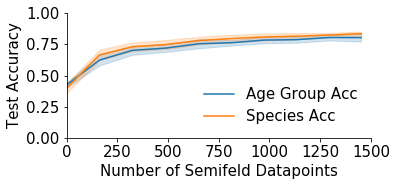

In [49]:
plt.rcParams.update({'font.size': 15})

outdir = "Results_Paper/"
build_folder(outdir, False)

savedir_main = (outdir+"Trian_Val_Only_Fix_Test_Retrain_Repeats/")
build_folder(savedir_main, False)

val_results = {'loss':[], 
               'age_group_loss':[], 
               'species_loss':[], 
               'age_group_acc':[], 
               'species_acc':[]}
# for i in [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]:
for i in [0]:
    val_results_load = load_obj(f'Validation_Results_Dict_{i}', savedir_main)
    val_results['loss'].append(np.array(val_results_load['loss']))
    val_results['age_group_loss'].append(np.array(val_results_load['age_group_loss']))
    val_results['species_loss'].append(np.array(val_results_load['species_loss']))
    val_results['age_group_acc'].append(np.array(val_results_load['age_group_acc']))
    val_results['species_acc'].append(np.array(val_results_load['species_acc']))
for i in [0.45]:
#     if i == 0.3:
#         val_results_load = load_obj(f'Validation_Results_Dict_{i}', savedir_main)
#         val_results['loss'].append(val_results_load['loss'][:-9][0])
#         val_results['age_group_loss'].append(val_results_load['age_group_loss'][:-9][0])
#         val_results['species_loss'].append(val_results_load['species_loss'][:-9][0])
#         val_results['age_group_acc'].append(val_results_load['age_group_acc'][:-9][0])
#         val_results['species_acc'].append(val_results_load['species_acc'][:-9][0])
# #         print(val_results_load['age_group_acc'][:-9][0])
#     else:
    val_results_load = load_obj(f'Validation_Results_Dict_{i}', savedir_main)
    val_results['loss'].append(np.array(val_results_load['loss']))
    val_results['age_group_loss'].append(np.array(val_results_load['age_group_loss']))
    val_results['species_loss'].append(np.array(val_results_load['species_loss']))
    val_results['age_group_acc'].append(np.array(val_results_load['age_group_acc']))
    val_results['species_acc'].append(np.array(val_results_load['species_acc']))
#         print(val_results_load['age_group_acc'])
    
# print(val_results["age_group_acc"])
# x = [0, 162, 324, 486, 654, 815, 973, 1131, 1294, 1452, 1566]
x = [0, 162, 324, 486, 654, 815, 973, 1131, 1294, 1452]

fig = plt.figure(figsize=(5.6,2.8))
# fig.suptitle('Time Course Validation Data Inclusion Study', fontsize=20, fontweight='bold')
ax = fig.add_subplot(111)
age_group_acc = np.concatenate(val_results["age_group_acc"]).reshape((-1,20))
species_acc = np.concatenate(val_results["species_acc"]).reshape((-1,20))
# age_group_acc = np.array(val_results["age_group_acc"]).reshape((-1,20))
# species_acc = np.array(val_results["species_acc"]).reshape((-1,20))
# print(age_group_acc.shape)
means_age = np.mean(age_group_acc, axis=1)
means_species = np.mean(species_acc, axis=1)
# print(means_age)
stds_age = np.std(age_group_acc, axis=1)
stds_species = np.std(species_acc, axis=1)
# print(stds_age)
ax.plot(x, means_age, lw=1.5, c='tab:blue', label="Age Group Acc")
ax.fill_between(x, means_age-stds_age, means_age+stds_age, color='tab:blue', alpha=0.2)
ax.plot(x, means_species, lw=1.5, c='tab:orange', label="Species Acc")
ax.fill_between(x, means_species-stds_species, means_species+stds_species, color='tab:orange', alpha=0.2)
ax.legend(loc='lower right', frameon=False)
ax.set_xlabel("Number of Semifeld Datapoints")
ax.set_ylabel("Test Accuracy")
# ax.set_xticks([0, 2.2, 4.3, 6.3, 8.3, 10.2, 11.9, 13.6, 15.2, 16.8])
ax.set_xlim([0,1500])
ax.set_ylim([0,1])
# ax.tick_params(axis='y', which='major')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.grid(True, axis='y', which='both')
plt.tight_layout(pad=1)
# for i,j in zip(x, means_age):
#     ax.annotate('{:1.2f}'.format(j), xy=(i,j), xytext=(i+0,j-0.06), color='b', arrowprops=dict(facecolor='black', width=1, headwidth=4, headlength=4, shrink=0.05))
# for i,j in zip(x, means_species):
#     ax.annotate('{:1.2f}'.format(j), xy=(i,j), xytext=(i+0,j+0.06), color='g', arrowprops=dict(facecolor='black', width=1, headwidth=4, headlength=4, shrink=0.05))
plt.savefig(savedir_main + "Validation_Study_Retrained_EV_Only.png")
plt.savefig(savedir_main + "Validation_Study_Retrained_EV_Only.pdf")
plt.show()
plt.close()

# UMAP visualisation of CNN embedding

Unused, but could be a cool idea!

In [35]:
## Name a folder for the outputs to go into
outdir = "Results_Paper/"
build_folder(outdir, False)

savedir_main = (outdir+"Trian_Val_Only_Fix_Test_Retrain_Repeats/")
build_folder(savedir_main, False)

model = load_model("/home/josh/Documents/Mosquito_Project/MIMI-Analysis/Models/Neural_Networks/CNN/Paper/Results_Paper/Trian_Lab_Field_V2/Baseline_CNN_Model.h5")
model.summary()
# model.layers.pop()
# model.layers.pop()
# model.layers.pop()
# model.layers.pop()
# model.layers.pop()
# model.summary()


inputs = model.input
predictions = model.layers[-5].output
model = Model(inputs=inputs, outputs=predictions)
sgd = keras.optimizers.SGD(lr=0.003, decay=1e-5, momentum=0.9, nesterov=True, clipnorm=1.)
cce = 'categorical_crossentropy'
model.compile(loss=cce, metrics=['acc'], 
                  optimizer=sgd)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
Conv1 (Conv1D)                  (None, 1618, 16)     144         input[0][0]                      
__________________________________________________________________________________________________
batchnorm_1 (BatchNormalization (None, 1618, 16)     64          Conv1[0][0]                      
__________________________________________________________________________________________________
max_pooling1d_56 (MaxPooling1D) (None, 1618, 16)     0           batchnorm_1[0][0]                
__________________________________________________________________________________________________
Conv2 (Con

In [24]:
# df = pd.read_csv("/home/josh/Documents/Mosquito_Project/New_Data/Data/MIMIdata/mosquitos_country.dat", '\t')
df = pd.read_csv("/home/josh/Documents/Mosquito_Project/New_Data/Data/MIMIdata_update_19_02/mosquitoes_country_LM_5_0.dat", '\t')
df.head(10)

df = df[df['Country']!='VB']

df['AgeGroup'] = 0
df['AgeGroup'] = np.where(df['Age']>10, 2, np.where(df['Age']>4, 1, 0))

Species_counts = df.groupby('Species').size()
print('{}'.format(Species_counts))
Status_counts = df.groupby('Status').size()
print('{}'.format(Status_counts))
RearCnd_counts = df.groupby('RearCnd').size()
print('{}'.format(RearCnd_counts))
age_counts = df.groupby('Age').size()
print('{}'.format(age_counts))
country_counts = df.groupby('Country').size()
print('{}'.format(country_counts))

X = df.iloc[:,6:-1]
y_age = df["Age"]
y_species = df["Species"]
y_status = df["Status"]
y_country = df["Country"]
y_age_groups = df["AgeGroup"]
y_rearcnd = df["RearCnd"]


print('shape of X : {}'.format(X.shape))
print('shape of y age : {}'.format(y_age.shape))
print('shape of y species : {}'.format(y_species.shape))
print('shape of y status : {}'.format(y_status.shape))
print('shape of y country : {}'.format(y_country.shape))
print('shape of y age groups : {}'.format(y_age_groups.shape))
print('shape of y rearcnd : {}'.format(y_rearcnd.shape))

X = np.asarray(X)
y_age = np.asarray(y_age)
y_species = np.asarray(y_species)
y_status = np.asarray(y_status)
y_country = np.asarray(y_country)
y_age_groups = np.asarray(y_age_groups)
y_rearcnd = np.asarray(y_rearcnd)

Species
AA    17251
AC     5995
AG    17481
dtype: int64
Status
BF     8611
GR     6737
SF    22102
UN     3277
dtype: int64
RearCnd
TF     9618
TL    27824
VF     3285
dtype: int64
Age
1     1596
2     1150
3     1530
4     2019
5     2323
6     2379
7     2630
8     2560
9     2796
10    2673
11    2704
12    2584
13    2816
14    2695
15    2869
16    2664
17    2739
dtype: int64
Country
B     8677
S     6430
T    25620
dtype: int64
shape of X : (40727, 1625)
shape of y age : (40727,)
shape of y species : (40727,)
shape of y status : (40727,)
shape of y country : (40727,)
shape of y age groups : (40727,)
shape of y rearcnd : (40727,)


In [25]:
X = np.expand_dims(X, axis=2)
print(X.shape)

(40727, 1625, 1)


In [36]:
y_predicted = model.predict(X)

In [37]:
print(np.array(y_predicted).shape)

(40727, 3168)


In [42]:
def plot_embedding_country(X, y, Species=None, saveDir=None, title=None, colorMap='Greys'):
    ## Sort the data
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    if Species is not None:
        uniqueSpecies = np.unique(Species)
    
    ## Start plotting
    colors = ['r', 'b', 'g', 'k']
    y_color = []
    y_label = []
    unique_y = np.unique(y)
    for i in y:
        lab_val = 0
        for lab in unique_y:
            if i == lab:
                y_color.append(colors[lab_val])
                if lab == 'S':
                    y_label.append('Glasgow')
                elif lab == 'T':
                    y_label.append('Ifakara')
                elif lab == 'B':
                    y_label.append('Bobo')
            lab_val += 1
    y_color = np.asarray(y_color)
    y_label = np.asarray(y_label)
    
    fig = plt.figure(figsize=(5.6,2.8))

    for i in range(len(uniqueSpecies)):
        ax = plt.subplot(1,len(uniqueSpecies),i+1)
        ## Get indicies of the species
        S = []
        L = []
        for j in range(len(unique_y)):
            indicies = np.where(np.logical_and(Species==uniqueSpecies[i], y==unique_y[j]))[0]
    #         L = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], cmap=colorMap, s=5) 
            if not list(indicies):
                pass
            else:
                S1 = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], label=y_label[indicies], s=0.1)       
                S.append(S1)
            if not list(y_label[indicies]):
                pass
            else:
                L.append(list(y_label[indicies])[0])

        plt.xticks([]), plt.yticks([])
        if uniqueSpecies[i] =='AA':
            plt.title('An. Arabiensis', fontsize=15)
        elif uniqueSpecies[i] =='AC':
            plt.title('An. Coluzzii', fontsize=15)
        elif uniqueSpecies[i] =='AG':
            plt.title('An. Gambiae', fontsize=15)
#     fig.legend((S), (L), loc='lower center', bbox_to_anchor=(0.5, -0.18), fontsize=18)
#     fig.legend((S), (L), loc='lower center', bbox_to_anchor=(0.5, -0.01), fontsize=15, markerscale=4.)
    
#     if title is not None:
#         fig.suptitle(title)        

    plt.savefig(saveDir+title+".pdf")
    
    fig = plt.figure(figsize=(5.6,2.8))

    for i in range(len(uniqueSpecies)):
        ax = plt.subplot(1,len(uniqueSpecies),i+1)
        ## Get indicies of the species
        S = []
        L = []
        for j in range(len(unique_y)):
            indicies = np.where(np.logical_and(Species==uniqueSpecies[i], y==unique_y[j]))[0]
    #         L = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], cmap=colorMap, s=5) 
            if not list(indicies):
                pass
            else:
                S1 = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], label=y_label[indicies], s=5)       
                S.append(S1)
            if not list(y_label[indicies]):
                pass
            else:
                L.append(list(y_label[indicies])[0])

        plt.xticks([]), plt.yticks([])
#         if uniqueSpecies[i] =='AA':
#             plt.title('An. Arabiensis', fontsize=15)
#         elif uniqueSpecies[i] =='AC':
#             plt.title('An. Coluzzii', fontsize=15)
#         elif uniqueSpecies[i] =='AG':
#             plt.title('An. Gambiae', fontsize=15)
#     fig.legend((S), (L), loc='lower center', bbox_to_anchor=(0.5, -0.18), fontsize=18)
    fig = plt.figure(figsize=(5.6,2.8))
    fig.legend((S), (L), loc='lower center', fontsize=15, markerscale=4.)
#     plt.tight_layout(pad=4)
#     if title is not None:
#         fig.suptitle(title)        

    plt.savefig(saveDir+title+"_legend.pdf", bbox_inches="tight")

In [44]:
def plot_embedding_rearCnd(X, y, Species=None, saveDir=None, title=None, colorMap='Greys'):
    ## Sort the data
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    if Species is not None:
        uniqueSpecies = np.unique(Species)
    
    ## Start plotting
    colors = ['r', 'b', 'g', 'o', 'p']
    y_color = []
    y_label = []
    unique_y = np.unique(y)
    for i in y:
        lab_val = 0
        for lab in unique_y:
            if i == lab:
                y_color.append(colors[lab_val])
                if lab == 'TF':
                    y_label.append('Time Course Field')
                elif lab == 'TL':
                    y_label.append('Time Course Lab')
                elif lab == 'VF':
                    y_label.append('Validation Field')
            lab_val += 1
    y_color = np.asarray(y_color)
    y_label = np.asarray(y_label)
    print(f'y_color shape : {y_color.shape}')
    print(f'y_label shape : {y_label.shape}')
    
    fig = plt.figure(figsize=(5.6,2.8))
    for i in range(len(uniqueSpecies)):
        ax = plt.subplot(1,len(uniqueSpecies),i+1)
        ## Get indicies of the species
        S = []
        L = []
        for j in range(len(unique_y)):
            indicies = np.where(np.logical_and(Species==uniqueSpecies[i], y==unique_y[j]))[0]
#             print(indicies)
    #         L = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], cmap=colorMap, s=5) 
            if not list(indicies):
                pass
            else:
                S1 = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], label=y_label[indicies], s=0.1)       
                S.append(S1)
            if not list(y_label[indicies]):
                pass
            else:
                L.append(list(y_label[indicies])[0])

        plt.xticks([]), plt.yticks([])
        if uniqueSpecies[i] =='AA':
            plt.title('An. Arabiensis', fontsize=15)
        elif uniqueSpecies[i] =='AC':
            plt.title('An. Coluzzii', fontsize=15)
        elif uniqueSpecies[i] =='AG':
            plt.title('An. Gambiae', fontsize=15)
#         plt.legend((S), (L), loc='lower center', bbox_to_anchor=(0.5, -0.1))
#     fig.legend((S), (L), loc='lower center', bbox_to_anchor=(0.5, -0.01), fontsize=18, markerscale=4.)

#     if title is not None:
#         fig.suptitle(title)        

    plt.savefig(saveDir+title+".pdf")
    
    fig = plt.figure(figsize=(5.6,2.8))
    for i in range(len(uniqueSpecies)):
        ax = plt.subplot(1,len(uniqueSpecies),i+1)
        ## Get indicies of the species
        S = []
        L = []
        for j in range(len(unique_y)):
            indicies = np.where(np.logical_and(Species==uniqueSpecies[i], y==unique_y[j]))[0]
#             print(indicies)
    #         L = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], cmap=colorMap, s=5) 
            if not list(indicies):
                pass
            else:
                S1 = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], label=y_label[indicies], s=5)       
                S.append(S1)
            if not list(y_label[indicies]):
                pass
            else:
                L.append(list(y_label[indicies])[0])

        plt.xticks([]), plt.yticks([])
        if uniqueSpecies[i] =='AA':
            plt.title('An. Arabiensis', fontsize=15)
        elif uniqueSpecies[i] =='AC':
            plt.title('An. Coluzzii', fontsize=15)
        elif uniqueSpecies[i] =='AG':
            plt.title('An. Gambiae', fontsize=15)
#         plt.legend((S), (L), loc='lower center', bbox_to_anchor=(0.5, -0.1))

    fig = plt.figure(figsize=(5.6,2.8))
    fig.legend((S), (L), loc='lower center', fontsize=18, markerscale=4.)

#     if title is not None:
#         fig.suptitle(title)        

    plt.savefig(saveDir+title+"_legend.pdf", bbox_inches="tight")

In [54]:
def plot_embedding_age(X, y, Species=None, saveDir=None, title=None, colorMap='Greys'):
    ## Sort the data
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    if Species is not None:
        uniqueSpecies = np.unique(Species)
    
    ## Start plotting
    colors = ['r', 'b', 'g', 'o', 'p']
    y_color = []
    y_label = []
    unique_y = np.unique(y)
    for lab in y:
        if lab <5:
            y_label.append('1-4')
            y_color.append(colors[0])
        elif lab < 11:
            y_label.append('5-10')
            y_color.append(colors[1])
        elif lab < 18:
            y_label.append('11-17')
            y_color.append(colors[2])
    y_color = np.asarray(y_color)
    y_label = np.asarray(y_label)
    print(f'y_color shape : {y_color.shape}')
    print(f'y_label shape : {y_label.shape}')
    
    fig = plt.figure(figsize=(5.6,2.8))
    for i in range(len(uniqueSpecies)):
        ax = plt.subplot(1,len(uniqueSpecies),i+1)
        ## Get indicies of the species
        S = []
        L = []
        for j in range(len(unique_y)):
            indicies = np.where(np.logical_and(Species==uniqueSpecies[i], y==unique_y[j]))[0]
#             print(indicies)
    #         L = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], cmap=colorMap, s=5) 
            if not list(indicies):
                pass
            else:
                S1 = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], label=y_label[indicies], s=0.1)       
                S.append(S1)
            if not list(y_label[indicies]):
                pass
            else:
                L.append(list(y_label[indicies])[0])

        plt.xticks([]), plt.yticks([])
        if uniqueSpecies[i] =='AA':
            plt.title('An. Arabiensis', fontsize=15)
        elif uniqueSpecies[i] =='AC':
            plt.title('An. Coluzzii', fontsize=15)
        elif uniqueSpecies[i] =='AG':
            plt.title('An. Gambiae', fontsize=15)
#         plt.legend((S), (L), loc='lower center', bbox_to_anchor=(0.5, -0.1))
#     fig.legend((S), (L), loc='lower center', bbox_to_anchor=(0.5, -0.01), fontsize=18, markerscale=4.)

#     if title is not None:
#         fig.suptitle(title)        

    plt.savefig(saveDir+title+".pdf")
    
    fig = plt.figure(figsize=(5.6,2.8))
    for i in range(len(uniqueSpecies)):
        ax = plt.subplot(1,len(uniqueSpecies),i+1)
        ## Get indicies of the species
        S = []
        L = []
        for j in range(len(unique_y)):
            indicies = np.where(np.logical_and(Species==uniqueSpecies[i], y==unique_y[j]))[0]
#             print(indicies)
    #         L = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], cmap=colorMap, s=5) 
            if not list(indicies):
                pass
            else:
                S1 = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], label=y_label[indicies], s=5)       
                S.append(S1)
            if not list(y_label[indicies]):
                pass
            else:
                L.append(list(y_label[indicies])[0])

        plt.xticks([]), plt.yticks([])
        if uniqueSpecies[i] =='AA':
            plt.title('An. Arabiensis', fontsize=15)
        elif uniqueSpecies[i] =='AC':
            plt.title('An. Coluzzii', fontsize=15)
        elif uniqueSpecies[i] =='AG':
            plt.title('An. Gambiae', fontsize=15)
#         plt.legend((S), (L), loc='lower center', bbox_to_anchor=(0.5, -0.1))

    fig = plt.figure(figsize=(5.6,2.8))
    fig.legend((S), (L), loc='lower center', fontsize=18, markerscale=4.)

#     if title is not None:
#         fig.suptitle(title)        

    plt.savefig(saveDir+title+"_legend.pdf", bbox_inches="tight")

In [41]:
num_neighbours = 32
num_min_dist = 0.7
num_metric = 'chebyshev'
## PCA embedding of the digits dataset
dimensions = 2
# print('Shape of X : {}'.format(X.shape))
print("Computing UMAP projection")
t0 = time()
#reducer = umap.UMAP(random_state=42, n_components=dimensions)
reducer = umap.UMAP(random_state=42, n_components=dimensions, n_neighbors=num_neighbours, metric=num_metric, min_dist=num_min_dist)
embedding = reducer.fit(y_predicted)
transformed = reducer.transform(y_predicted)
print('Embedding time: {}'.format(time()-t0))

Computing UMAP projection
Embedding time: 207.33830881118774


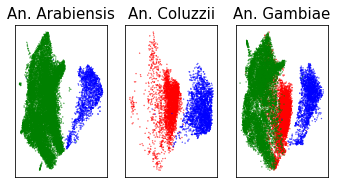

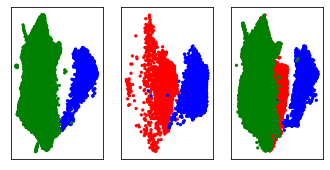

<Figure size 403.2x201.6 with 0 Axes>

In [43]:
plot_embedding_country(transformed, y_country, y_species, savedir_main, ('UMAP_Embedded_Mosquito_Country'), colorMap='Set1')


y_color shape : (40727,)
y_label shape : (40727,)


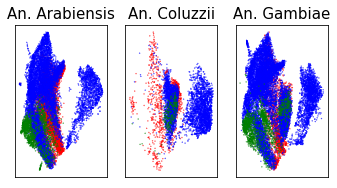

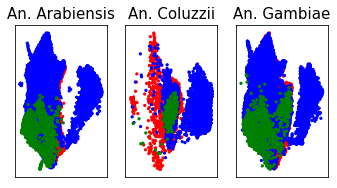

<Figure size 403.2x201.6 with 0 Axes>

In [45]:
plot_embedding_rearCnd(transformed, y_rearcnd, y_species, savedir_main, ('UMAP_Embedded_Mosquito_RearCnd'), colorMap='Set1')


y_color shape : (40727,)
y_label shape : (40727,)


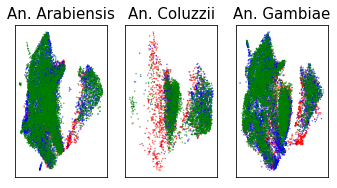

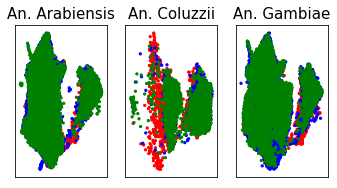

<Figure size 403.2x201.6 with 0 Axes>

In [55]:
plot_embedding_age(transformed, y_age, y_species, savedir_main, ('UMAP_Embedded_Mosquito_Age'), colorMap='Set1')
